In [25]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [26]:
# Create list of all targets (minus background noise)
dataset_path = 'C:\\\\MCT - IoT Engineer\\\\Research Project\\\\data_speech_commands_v0.02'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [27]:
# Settings
feature_sets_path = 'C:\\MCT - IoT Engineer\\Research Project\\data train'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_on_model.h5'
wake_word = 'off'

In [28]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [29]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [30]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77509, 16, 16)
(9667, 16, 16)
(9680, 16, 16)


In [31]:
# Peek at labels
print(y_val)

[33. 27. 29. ... 16. 12. 30.]


In [32]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [33]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. ... 0. 0. 0.]


In [34]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.03672287162511637
0.9632771283748837


In [35]:
# View the dimensions of our input data
print(x_train.shape)

(77509, 16, 16)


In [36]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77509, 16, 16, 1)
(9667, 16, 16, 1)
(9680, 16, 16, 1)


In [37]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [38]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [39]:
# Display model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 32)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 32)            │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 2, 2, 64)            │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [41]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.9664 - loss: 0.1233 - val_acc: 0.9747 - val_loss: 0.0759
Epoch 2/30
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9767 - loss: 0.0700 - val_acc: 0.9834 - val_loss: 0.0525
Epoch 3/30
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9815 - loss: 0.0571 - val_acc: 0.9848 - val_loss: 0.0478
Epoch 4/30
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9831 - loss: 0.0525 - val_acc: 0.9855 - val_loss: 0.0446
Epoch 5/30
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9844 - loss: 0.0478 - val_acc: 0.9852 - val_loss: 0.0503
Epoch 6/30
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.9864 - loss: 0.0426 - val_acc: 0.9770 - val_loss: 0.0699
Epoch 7/30
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9858 - loss: 0.0416 - val_acc: 0.9864 - val_loss: 0.0407
Epoch 8/30
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9874 - loss: 0.0393 - val_acc: 0.9855 - val_loss: 0.0498
Epoch 9/30
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - ac

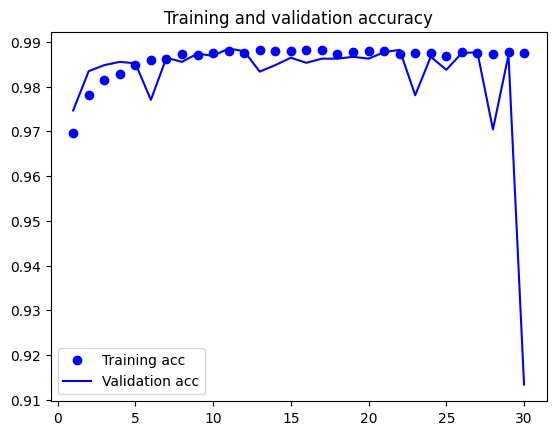

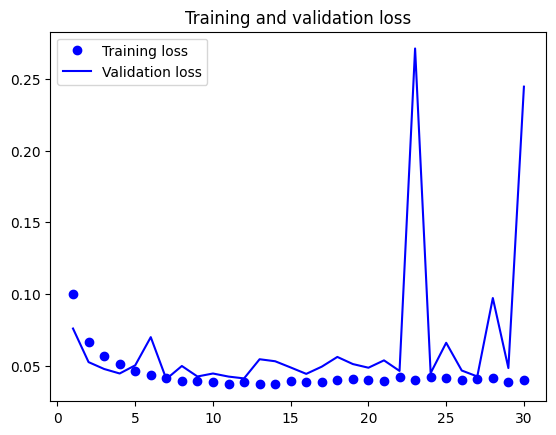

In [42]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
# Save the model as a file
models.save_model(model, model_filename)

In [44]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

40
42
78
117
157
174
176
184
197
260
344
360
372
430
459
465
489
522
527
541
562
566
633
652
654
721
727
730
752
760
770
780
841
851
853
887
903
1039
1084
1103
1207
1216
1256
1283
1293
1320
1378
1409
1470
1472
1537
1599
1626
1630
1666
1676
1754
1801
1808
1844
1845
1856
1858
1868
1883
1898
1924
1978
1991
2004
2045
2048
2158
2163
2225
2236
2238
2248
2265
2297
2336
2389
2398
2399
2414
2423
2459
2482
2501
2520
2586
2660
2702
2722
2742
2817
2830
2835
2846
2934
2964
2983
3035
3134
3140
3147
3176
3211
3214
3336
3342
3380
3396
3399
3430
3500
3509
3530
3579
3657
3696
3701
3735
3819
3865
3873
3875
3935
3940
3953
3964
3987
3995
4000
4009
4043
4056
4203
4204
4205
4275
4302
4312
4338
4354
4372
4393
4402
4454
4479
4493
4494
4497
4521
4541
4596
4599
4608
4634
4651
4680
4704
4708
4723
4809
4845
4847
4865
4881
4897
4904
4944
5013
5023
5047
5064
5130
5133
5184
5187
5206
5279
5302
5306
5312
5363
5377
5392
5464
5509
5538
5552
5623
5627
5654
5659
5671
5689
5695
5861
5863
5864
5900
5916
5943
5962
5966
5967


In [45]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Answer: 0.0  Prediction: [[0.00158977]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Answer: 0.0  Prediction: [[0.00060197]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Answer: 0.0  Prediction: [[0.29499894]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Answer: 0.0  Prediction: [[0.12524043]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Answer: 0.0  Prediction: [[8.273707e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Answer: 0.0  Prediction: [[3.035888e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Answer: 0.0  Prediction: [[0.00892611]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Answer: 0.0  Prediction: [[1.2218313e-13]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Answer: 0.0  Prediction: [[3.1614388e-16]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Answer: 0.0  Prediction: [[2.443148e-05]]


In [46]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.9151 - loss: 0.2385


[0.22856250405311584, 0.9198347330093384]